In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am
import matplotlib.colors as mcolors
from scipy.optimize import minimize
import data_processing 
from functools import reduce
from scipy.spatial import Delaunay, SphericalVoronoi
from itertools import compress, chain
np.set_printoptions(precision=3, suppress=True)

In [2]:
filenames = [
    '32-cell H1 inj in PCNA_12052023-01_AcquisitionBlock1_pt1_Detailed.csv', 
    '32-cell H1 inj in PCNA_12052023-01_AcquisitionBlock2_pt2_Detailed.csv', 
    '32c H1 inj_19052023-01_AcquisitionBlock1_pt1_Detailed.csv',
    '32c H1 inj_19052023-01_AcquisitionBlock2_pt2_Detailed.csv',
    '32c H1 inj_25052023-01-1_AcquisitionBlock1_pt1_Detailed.csv',
    '32c H1 inj_25052023-01-1_AcquisitionBlock2_pt2_Detailed.csv' 
]

frame_to_times = [
    39, 39, 39, 39, 39, 39
]
headers = [2, 2, 2, 2, 2, 2, 2]


round_frames = [    
    [0, 37, 81, 130, 190],
    [0,  40,  86, 143, 196],
    [13,  57, 102, 138, 191, 248],
    [0,  48,  78, 132, 188, 243],
    [0,  13,  52,  98, 142, 203],
    [0,  30,  60, 104, 159, 198, 220]
]

n = 1

filename = 'data/'+filenames[n]
f_start = np.array(round_frames[n])

p = data_processing.Processor(filename, headers[n], frame_to_times[n], inject=True)

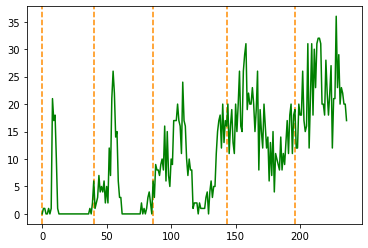

[0, 40, 86, 143, 196]


In [3]:
z_cutoff = 10
p.process(f_start=round_frames[n], z_cutoff=z_cutoff)

divs = np.array([d['count']-np.sum(d['z']<z_cutoff) for d in p.divisions])

for f in p.f_start: 
    plt.axvline(x=f, color='darkorange', linestyle='--')
plt.plot(divs, 'g-')
plt.show() 

print(repr(p.f_start))

In [5]:
spherical_polar = p.get_spherical_polar(1) 
p.label_surface_cells(spherical_polar)

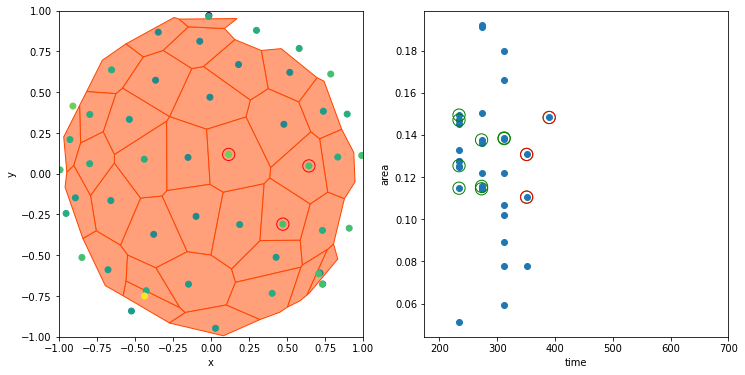

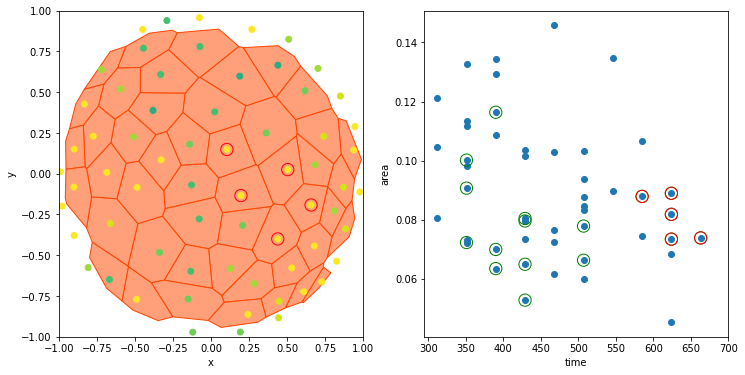

In [10]:
for index in range(0, 2):
    s = p.rounds[index]['sur'] 
    r = p.rounds[index]['coor'][s] # coordinate of all surface cells 
    inj =  p.rounds[index]['inj'][s]

    mz = r[:, 2] > z_cutoff 
    
    polar = np.array(spherical_polar[index])[s]
    d, phi, theta, D = polar.T
    
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta) 
    points = np.stack([x, y, z]).T   
    
    vor = SphericalVoronoi(points)
    vor.sort_vertices_of_regions()
    vertex_set = np.unique(list(chain.from_iterable(compress(vor.regions, inj))))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    m_region = np.ones(len(vor.regions))
    m_nn = np.zeros(len(vor.regions))
    for (i, region) in enumerate(vor.regions):
        poly = vor.vertices[region]
        if np.all(poly[:, -1] > 0):
            axes[0].fill(poly[:, 0], poly[:, 1], facecolor='lightsalmon', edgecolor='orangered', linewidth=1)
        else:
            m_region[i] = 0 
        if any([v in vertex_set for v in region]): # if the region is next to any injected cells 
            m_nn[i] = 1  

            
    m_region = m_region.astype('bool')
    m_nn = m_nn.astype('bool')

    axes[0].scatter(x[mz], y[mz], c=r[:, -1][mz]-np.min(r[:, -1]), vmin=0, vmax=500)
    axes[0].scatter(x[mz & inj ], y[mz & inj], s=150, facecolors='none', edgecolors='r')
    
    axes[0].set_xlim([-1, 1])
    axes[0].set_ylim([-1, 1])
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    areas = vor.calculate_areas()
    axes[1].scatter(r[:, -1][m_region & mz]-np.min(r[:, -1]), areas[m_region & mz])
    axes[1].scatter(r[:, -1][m_region&mz&m_nn]-np.min(r[:, -1]), areas[m_region&mz&m_nn], s=150, facecolors='none', edgecolors='g')
    axes[1].scatter(r[:, -1][m_region&mz&inj]-np.min(r[:, -1]), areas[m_region&mz&inj], s=150, facecolors='none', edgecolors='r')
    axes[1].set_ylabel('area')
    axes[1].set_xlabel('time')
    axes[1].set_xlim([None, 700])

    plt.show()